## Notebook for checking similarity

### Random splitting

**Created on 5th April, 2022; re-modified on 31st August**

Note: copied from LGBM folder

In [28]:
import warnings
warnings.filterwarnings('ignore')
import requests
#from selenium import webdriver
import os
import json
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import math
from rdkit import Chem
from sklearn.model_selection import train_test_split
from rdkit.Chem.MolStandardize import rdMolStandardize
# from ifg import identify_functional_groups ## Need ifg.py file
import rdkit.Chem.rdMolDescriptors as MolDescriptors
import rdkit.Chem.Descriptors as Descriptors
import rdkit.Chem.Lipinski as Lipinski
from rdkit.Chem import Descriptors3D
from rdkit.Chem import AllChem, DataStructs, Fragments
from mordred import Calculator, descriptors, CPSA
from mordred.GeometricalIndex import Radius3D, Diameter3D, GeometricalShapeIndex

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshkumar/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/ionic-conductivity_2.0/chemprop/multicomp-dataset/2D-feat/random-split
total 552
drwx------  20 riteshkumar  staff       640 Aug 30  2022 old-hyp-wo-mw-salt
-rw-------@  1 riteshkumar  staff     64540 Aug 31  2022 split_dataset.ipynb
-rw-r--r--@  1 riteshkumar  staff     69407 Aug 31  2022 val_multi_comp_comb.csv
-rw-r--r--@  1 riteshkumar  staff     72447 Aug 31  2022 val_multi_comp_add.csv
-rw-r--r--@  1 riteshkumar  staff    554867 Aug 31  2022 train_multi_comp_comb.csv
-rw-r--r--@  1 riteshkumar  staff    586008 Aug 31  2022 train_multi_comp_add.csv
-rw-r--r--@  1 riteshkumar  staff     69314 Aug 31  2022 test_multi_comp_comb.csv
-rw-r--r--@  1 riteshkumar  staff     73239 Aug 31  2022 test_multi_comp_add.csv
-rw-------@  1 riteshkumar  staff   1477871 Aug 31  2022 sel_rdkit_features_complete_data.csv
-rw-r--r--@  1 riteshkumar  staff      4162 Aug 31  2022 list_solv_multicomp.csv
-rw-r--r--@  1 

In [3]:
df_comp = pd.read_csv('../all_multi_comp.csv')
df_comp

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.459589
1,O=C1OCCO1,CCCCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.774952
2,O=C1OCCO1,CC(C)COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.686399
3,O=C1OCCO1,CCC(C)OC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.871802
4,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.741937
...,...,...,...,...,...,...
10191,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.547563
10192,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.624669
10193,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.772589
10194,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.687847


In [ ]:
df = pd.read_csv('fgrp_2d_feat_all_multi_comp.csv')
df

In [5]:
## My version of calculating frequency
cols = df_comp.columns
def frequency_count(df_comp):
    freq_dct = {}
    for i in range(len(df_comp)):
        for j in range(4):
            if df_comp[cols[j]][i] != np.nan:
                freq_dct[df_comp[cols[j]][i]] = freq_dct.get(df_comp[cols[j]][i],0)+1
            else:
                pass
    del freq_dct[np.nan]
    return freq_dct

dct = frequency_count(df_comp)
dct

{'O=C1OCCO1': 2078,
 'COC(=O)OC': 581,
 'CCCCOC(=O)OC': 1,
 'CC(C)COC(=O)OC': 1,
 'CCC(C)OC(=O)OC': 1,
 'CCOC(=O)OCC': 2487,
 'CCOC(=O)OC(C)F': 14,
 'CC(OC(=O)OCC(F)(F)F)F': 11,
 'FC1COC(=O)O1': 51,
 'C1(C(OC(=O)O1)F)F': 23,
 'CCOC(=O)OC': 704,
 'FC(F)C(F)(F)COC(F)(F)C(F)F': 31,
 'C1C(OC(=O)O1)CC(C(F)(F)F)(C(F)(F)F)F': 15,
 'COC(=O)OCC(F)(F)F': 10,
 'COC(F)(C(F)(F)C(F)(F)F)C(F)(C(F)(F)F)C(F)(F)F': 5,
 'CC(OC(F)(F)C(F)C(F)(F)F)C(F)(F)C(F)C(F)(F)F': 15,
 'CC1COC(=O)O1': 5885,
 'CCOCCOCC': 55,
 'ClCCl': 94,
 'C1CCOC1': 292,
 'Cc1ccccc1': 39,
 'CC1CCCO1': 270,
 'COCCOC': 729,
 'C1COCO1': 153,
 'O=c1occo1': 10,
 'C=CCCCOCC1COC(=O)O1': 5,
 'CO[Si](CCCOCC1COC(=O)O1)(OC)OC': 5,
 'CCO[Si](CCCOCC1COC(=O)O1)(OCC)OCC': 5,
 'C[Si](C)(C)O[Si](C)(C)CCCOCC1COC(=O)O1': 5,
 'CCCC(=O)OC': 6,
 'CN1CCCC1=O': 1,
 'CCCCOCCOCCCC': 19,
 'COP(=O)(OC)OC': 5,
 'O=C1CCCO1': 415,
 'COC(=O)OCCCF': 5,
 'CCCOC(=O)OC': 21,
 'COC(=O)OCCC(F)(F)F': 5,
 'COC(=O)OCC(F)(F)C(F)F': 5,
 'COC(=O)OCC(F)(F)C(F)(F)F': 5,
 'O=C1OCC(

In [24]:
solv_df = pd.DataFrame({'solv_smiles':list(dct.keys()), 'freq':list(dct.values())})
solv_df.sort_values(by='freq', ascending=False, inplace=True)
solv_df.reset_index(drop=True, inplace=True)
solv_df
dct_solv_list = list(solv_df['solv_smiles'])
dct_freq_list = list(solv_df['freq'])
dct_freq_list

[5885,
 2487,
 2078,
 799,
 729,
 704,
 581,
 415,
 415,
 374,
 292,
 270,
 209,
 193,
 168,
 153,
 128,
 115,
 113,
 108,
 94,
 80,
 73,
 59,
 58,
 55,
 55,
 54,
 51,
 44,
 40,
 40,
 40,
 39,
 36,
 33,
 31,
 31,
 30,
 29,
 28,
 25,
 23,
 21,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 19,
 18,
 18,
 18,
 18,
 16,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 12,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

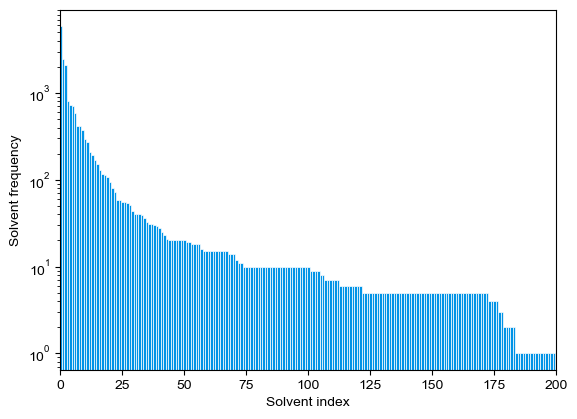

In [70]:
x = [i for i in range(len(dct_solv_list))]
bins = np.linspace(0, 6000, 50)
# dct_freq_list_sorted = dct_freq_list.sort()
dct_freq_list_1 = [i for i in dct_freq_list if i <= 15]; x_1 = [i for i in range(len(dct_freq_list_1))]
dct_freq_list_2 = [i for i in dct_freq_list if i > 15 and i < 100]; x_2 = [i+x_1[-1] for i in range(len(dct_freq_list_2))]
dct_freq_list_3 = [i for i in dct_freq_list if i >= 100]; x_3 = [i+x_2[-1] for i in range(len(dct_freq_list_3))]
# x_1.sort(); x_2.sort(); x_3.sort()
plt.bar(x, dct_freq_list, align='center', width=1.0, edgecolor='w', color=(0, 0.576, 0.902), linewidth=0.5)  ## using just one color
# plt.bar(x_3, dct_freq_list_3, align='center', width=2.5, edgecolor='w', color=(0, 0.576, 0.902)) ## using 3 colors (not used finally)
# plt.bar(x_2, dct_freq_list_2, align='center', width=2.5, edgecolor='w', color=(0.298, 0.78, 0.77))
# plt.bar(x_1, dct_freq_list_1, align='center', width=2.5, edgecolor='w', color=(0.984, 0.713, 0.305))
# for i in range(3):
#     plt.hist(dct_freq_list, bins=bins, histtype='step', linewidth=2.5, label='{}-{}'.format(i*15, (i+1)*15))
plt.xlim(0, 200)
plt.ylabel('Solvent frequency')
plt.xlabel('Solvent index')
plt.gca().set_yscale('log')
plt.gca().set_aspect(35.0)
# x_1

In [49]:
x_3

[190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209]

In [20]:
y = df.iloc[:,-1]
y

0        2.459589
1        1.774952
2        1.686399
3        1.871802
4        0.741937
           ...   
10191    1.547563
10192    2.624669
10193    2.772589
10194    2.687847
10195    0.746688
Name: conductivity_log, Length: 10196, dtype: float64

In [21]:
rest_df, test_df, y_rest, y_test = train_test_split(df_comp, y, test_size=0.1, random_state=0)
test_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
6642,CC1COC(=O)O1,O=C1OCCO1,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.063161
3424,CC1COC(=O)O1,CCOC(=O)OCC,NaN,NaN,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,2.004640
3779,CC1COC(=O)O1,O=C1OCCO1,NaN,NaN,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,2.011817
7066,CC1COC(=O)O1,CCOC(=O)OCC,NaN,NaN,[Li+].[B-](F)(F)(F)F,-1.681759
176,O=C1OCCO1,NaN,NaN,NaN,[Li+].F[As-](F)(F)(F)(F)F,2.754934
...,...,...,...,...,...,...
7780,CC1CCCO1,O=C1OCCO1,CC1COC(=O)O1,NaN,[Li+].F[As-](F)(F)(F)(F)F,1.266948
7497,C1COB(OCCOB2OCCCO2)OC1,NaN,NaN,NaN,[Li+].[O-]Cl(=O)(=O)=O,-8.727914
5473,CC1COC(=O)O1,CCOC(=O)OCC,NaN,NaN,CC[N+](CC)(CC)CC.F[P-](F)(F)(F)(F)F,2.120264
8756,COCCOCCOCCOCCOC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.079429


In [22]:
y_test

6642    2.063161
3424    2.004640
3779    2.011817
7066   -1.681759
176     2.754934
          ...   
7780    1.266948
7497   -8.727914
5473    2.120264
8756    1.079429
1455    2.227525
Name: conductivity_log, Length: 1020, dtype: float64

In [23]:
train_df, val_df, y_train, y_val = train_test_split(rest_df, y_rest, test_size=0.11, random_state=0)
train_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
8357,CCOCCOCCF,O=C1OCCO1,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.887070
4397,CC1COC(=O)O1,NaN,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.077993
4649,CC1COC(=O)O1,CCOC(=O)OCC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.362224
8266,COCCOC,COCCOCC(F)(F)C(F)F,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.857859
1124,CC1COC(=O)O1,NaN,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.629241
...,...,...,...,...,...,...
102,FC(F)C(F)(F)COC(F)(F)C(F)F,COC(=O)OCC(F)(F)F,O=C1OCCO1,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.098612
1664,CCCCCCCCCC1COC(=O)O1,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[O-],-3.028255
8946,COCCOCCOCCOCCOC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.182280
2190,CC1COC(=O)O1,CCOC(=O)OCC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.515274


In [24]:
val_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
1992,O=C1OCCO1,CCOC(=O)OC,CC(=O)OC,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.541602
9701,CS(=O)(=O)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.576613
7558,C1COB(OCCOB2OCCCO2)OC1,O=C1OCCO1,NaN,NaN,[Li+].[O-]Cl(=O)(=O)=O,2.271271
7189,O=C1CCCO1,NaN,NaN,NaN,[B-](C1=CC=CC=C1)(C2=CC=CC=C2)(C3=CC=CC=C3)C4=...,-1.525329
2568,CC1COC(=O)O1,CCOC(=O)OCC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.332102
...,...,...,...,...,...,...
1822,O=C1OCCO1,CCOC(=O)OC,COC(=O)OC,NaN,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0.683489
2923,CC1COC(=O)O1,NaN,NaN,NaN,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,1.087214
6641,CC1COC(=O)O1,O=C1OCCO1,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.389038
6578,CC1COC(=O)O1,CCOC(=O)OCC,NaN,NaN,[B-](F)(F)(F)F.CC[N+](CC)(CC)CC,1.590862


In [25]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [29]:
val_freq = frequency_count(val_df)
val_solv = list(val_freq.keys())
val_freq

{'O=C1OCCO1': 305,
 'CCOC(=O)OC': 76,
 'CC(=O)OC': 29,
 'CS(=O)(=O)F': 2,
 'C1COB(OCCOB2OCCCO2)OC1': 9,
 'O=C1CCCO1': 52,
 'CC1COC(=O)O1': 593,
 'CCOC(=O)OCC': 231,
 'CCS(=O)(=O)CC1CCCCC1': 3,
 'COCCOC': 69,
 'CCCC[N+]1(CCCC1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': 6,
 'COC(=O)OC': 64,
 'CS(=O)(=O)CC1CCCC1': 1,
 'N#CCCC#N': 15,
 'C1CCOC1': 25,
 'COCC(F)(F)C(F)(F)COC': 1,
 'CCOC(=O)C': 35,
 'COCOC': 11,
 'CS(=O)(=O)C': 1,
 'O=S1(=O)CCCC1': 29,
 'CCCCOCCOCCCC': 1,
 'CC(OC(=O)OCC(F)(F)F)F': 1,
 'CC1CCCO1': 24,
 'Cc1ccccc1': 5,
 'CC#N': 19,
 'COCCOCCOCCOCCOC': 11,
 'N#CCCCCC#N': 7,
 'COC(=O)OCF': 5,
 'CS(=O)C': 5,
 'ClCCl': 11,
 'FC(F)C(F)(F)COC(F)(F)C(F)F': 8,
 'COC(=O)OCC(F)(F)F': 1,
 'C1C(OC(=O)O1)CC(C(F)(F)F)(C(F)(F)F)F': 1,
 'COCCO[Si](CCC#N)(OCCOC)OCCOC': 1,
 'C1COCO1': 16,
 'COCCOCCOCCOC': 15,
 'CCCCCCC1COC(=O)O1': 2,
 'N#CCCOCC(F)(F)F': 1,
 'O=C1OCCC1F': 2,
 'O=C1CC(F)CO1': 2,
 'C[Si](C)(C)O[Si](C)(C)CCC1COC(=O)O1': 3,
 'CCO[Si](CCCOCC1COC(=O)O1)(OCC)OCC': 1,
 'CCOCCOCC': 4,
 

In [41]:
# def find_unique(df):
#     solv_sm = []; salt_sm = []
#     for i in range(len(df)):
#         salt_sm.append(df['salt_sm'][i])
#         for j in range(4):
#             # if df[cols[j]][i] != '':
#             solv_sm.append(df[cols[j]][i])
#     solv_sm_arr = list(set(solv_sm))
#     salt_sm_arr = list(set(salt_sm))
#     solv_sm_arr.remove(np.nan)
#     return solv_sm_arr, salt_sm_arr

In [30]:
train_freq = frequency_count(train_df)
train_solv = list(train_freq.keys())
train_freq

{'CCOCCOCCF': 8,
 'O=C1OCCO1': 2296,
 'CC1COC(=O)O1': 4689,
 'CCOC(=O)OCC': 1973,
 'COCCOC': 597,
 'COCCOCC(F)(F)C(F)F': 16,
 'CS(=O)(=O)F': 3,
 'COCCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCCOC': 9,
 'CC#N': 163,
 'C=CCCCOCC1COC(=O)O1': 4,
 'COC(=O)OC': 458,
 'O=C1CCCO1': 384,
 'C1COCO1': 119,
 'COCOC': 89,
 'CCS(C)(=O)=O': 27,
 'C1COB(OCCOB2OCCCO2)OC1': 91,
 'FC(F)(F)COCCOCC(F)(F)F': 18,
 'CC(=O)OC': 124,
 'CCOC(=O)C': 346,
 'COB(OC)OC': 13,
 'N#CCCOB(OCCC#N)OCCC#N': 17,
 'O=S1(=O)CCCC1': 318,
 'Cc1ccccc1': 73,
 'COCCOCCOCCOC': 161,
 'CCCOC(=O)OC': 18,
 'OCCOCCOCCOCCOCCOCCOCCOCCO': 3,
 'C1CCOC1': 245,
 'CC(OC(F)(F)C(F)C(F)(F)F)C(F)(F)C(F)C(F)(F)F': 10,
 'ClCCl': 82,
 'CCOC(=O)OC': 572,
 'C[Si](C)(C)O[Si](C)(C)CCC1COC(=O)O1': 15,
 'C[N+](=O)[O-]': 6,
 'N#CCCCC#N': 24,
 'CCCC#N': 29,
 'CC1CCCO1': 220,
 'CCOCCOCC': 46,
 'C1=CC=C(C=C1)F': 3,
 'CCCCOCCOCCCC': 17,
 'C[Si](C)(C)O[Si](C)(CCC1COC(=O)O1)O[Si](C)(C)C': 35,
 'COCCOCC(F)F': 10,
 'COCCOCCOCCO[Si](C)(C)C': 5,
 'COCCOCCOCCO

In [31]:
test_freq = frequency_count(test_df)
test_solv = list(test_freq.keys())
test_freq

{'CC1COC(=O)O1': 603,
 'O=C1OCCO1': 276,
 'CCOC(=O)OCC': 283,
 'COCCOC': 63,
 'FC(F)C(F)(F)COC(F)(F)C(F)F': 2,
 'C1COB(OCCOB2OCCCO2)OC1': 15,
 'N#CCCC#N': 19,
 'FC1COC(=O)O1': 6,
 'CC1CCC(O1)C': 2,
 'C1COCO1': 18,
 'COCCOCC(F)(F)C(F)F': 3,
 'CS(=O)C': 12,
 'CCOC(=O)C': 34,
 'CCOC(=O)OC': 56,
 'COCCOCCOCCOC': 17,
 'CCS(=O)(=O)CCOCCOC': 2,
 'CC#N': 27,
 'CC1CCCO1': 26,
 'COC(=O)OCF': 9,
 'CCOP(=O)(OCC)OCC': 1,
 'C(C(F)(F)F)OCC(F)(F)F': 1,
 'COCCOCCOC': 7,
 'CC1CCS(=O)(=O)C1': 3,
 'O=C1CCCO1': 38,
 'COCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCOC': 1,
 'O=S1(=O)CCCC1': 27,
 'CCOCCOCC': 5,
 'COC(=O)OC': 59,
 'COCOC': 8,
 'CCOCCOCC(F)F': 1,
 'CC(=O)OC': 15,
 'C1CCOC1': 22,
 'N#CCCCCC#N': 6,
 'CCCCCCC1COC(=O)O1': 1,
 'N#CCCOCC(F)(F)F': 1,
 'COCCO[Si](CCC#N)(OCCOC)OCCOC': 1,
 'CC(=O)OCCF': 2,
 'C[Si](C)(C)OCCC#N': 1,
 'C[Si](C)(C)O[Si](C)(CCC1COC(=O)O1)O[Si](C)(C)C': 2,
 'CCS(=O)(=O)C1CCCC1': 1,
 'COCCOCCOCCNC(=S)NCCOCCOCCOC': 1,
 'ClCCl': 16,
 'COCCOCC(F)(F)F': 5,
 'COCCO[Si](C)(CCC#

In [32]:
ref_mol = [Chem.MolFromSmiles(sm) for sm in train_solv]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

In [33]:
def check_similarity(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    similarity = [DataStructs.FingerprintSimilarity(mol_fps, ref) for ref in ref_fps]
    max_sim = max(similarity)
    # max_sim = 1.0
    # ind = similarity.index(max_sim)
    return max_sim

**similarity for validation-train**

In [34]:
val_solv_max_sim = []
for i in range(len(val_solv)):
    max_sim = check_similarity(val_solv[i])
    print(val_solv[i], max_sim)
    val_solv_max_sim.append(max_sim)

O=C1OCCO1 1.0
CCOC(=O)OC 1.0
CC(=O)OC 1.0
CS(=O)(=O)F 1.0
C1COB(OCCOB2OCCCO2)OC1 1.0
O=C1CCCO1 1.0
CC1COC(=O)O1 1.0
CCOC(=O)OCC 1.0
CCS(=O)(=O)CC1CCCCC1 1.0
COCCOC 1.0
CCCC[N+]1(CCCC1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F 1.0
COC(=O)OC 1.0
CS(=O)(=O)CC1CCCC1 1.0
N#CCCC#N 1.0
C1CCOC1 1.0
COCC(F)(F)C(F)(F)COC 0.4090909090909091
CCOC(=O)C 1.0
COCOC 1.0
CS(=O)(=O)C 1.0
O=S1(=O)CCCC1 1.0
CCCCOCCOCCCC 1.0
CC(OC(=O)OCC(F)(F)F)F 1.0
CC1CCCO1 1.0
Cc1ccccc1 1.0
CC#N 1.0
COCCOCCOCCOCCOC 1.0
N#CCCCCC#N 1.0
COC(=O)OCF 1.0
CS(=O)C 1.0
ClCCl 1.0
FC(F)C(F)(F)COC(F)(F)C(F)F 1.0
COC(=O)OCC(F)(F)F 1.0
C1C(OC(=O)O1)CC(C(F)(F)F)(C(F)(F)F)F 1.0
COCCO[Si](CCC#N)(OCCOC)OCCOC 1.0
C1COCO1 1.0
COCCOCCOCCOC 1.0
CCCCCCC1COC(=O)O1 1.0
N#CCCOCC(F)(F)F 1.0
O=C1OCCC1F 1.0
O=C1CC(F)CO1 1.0
C[Si](C)(C)O[Si](C)(C)CCC1COC(=O)O1 1.0
CCO[Si](CCCOCC1COC(=O)O1)(OCC)OCC 1.0
CCOCCOCC 1.0
CS(N)(=O)=O 1.0
CCOC(=O)C(F)F 1.0
CC1CCS(=O)(=O)C1 1.0
COCCOC(=O)OC 1.0
CCCC#N 1.0
COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC 1.0
C[Si](C)(C)O[Si]

In [35]:
np.mean(np.array(val_solv_max_sim))

0.9909494100670571

**test-train**

In [36]:
test_solv_max_sim = []
for i in range(len(test_solv)):
    max_sim = check_similarity(test_solv[i])
    print(test_solv[i], max_sim)
    test_solv_max_sim.append(max_sim)

CC1COC(=O)O1 1.0
O=C1OCCO1 1.0
CCOC(=O)OCC 1.0
COCCOC 1.0
FC(F)C(F)(F)COC(F)(F)C(F)F 1.0
C1COB(OCCOB2OCCCO2)OC1 1.0
N#CCCC#N 1.0
FC1COC(=O)O1 1.0
CC1CCC(O1)C 1.0
C1COCO1 1.0
COCCOCC(F)(F)C(F)F 1.0
CS(=O)C 1.0
CCOC(=O)C 1.0
CCOC(=O)OC 1.0
COCCOCCOCCOC 1.0
CCS(=O)(=O)CCOCCOC 1.0
CC#N 1.0
CC1CCCO1 1.0
COC(=O)OCF 1.0
CCOP(=O)(OCC)OCC 1.0
C(C(F)(F)F)OCC(F)(F)F 1.0
COCCOCCOC 1.0
CC1CCS(=O)(=O)C1 1.0
O=C1CCCO1 1.0
COCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCOC 1.0
O=S1(=O)CCCC1 1.0
CCOCCOCC 1.0
COC(=O)OC 1.0
COCOC 1.0
CCOCCOCC(F)F 1.0
CC(=O)OC 1.0
C1CCOC1 1.0
N#CCCCCC#N 1.0
CCCCCCC1COC(=O)O1 1.0
N#CCCOCC(F)(F)F 1.0
COCCO[Si](CCC#N)(OCCOC)OCCOC 1.0
CC(=O)OCCF 1.0
C[Si](C)(C)OCCC#N 1.0
C[Si](C)(C)O[Si](C)(CCC1COC(=O)O1)O[Si](C)(C)C 1.0
CCS(=O)(=O)C1CCCC1 1.0
COCCOCCOCCNC(=S)NCCOCCOCCOC 1.0
ClCCl 1.0
COCCOCC(F)(F)F 1.0
COCCO[Si](C)(CCC#N)OCCOC 1.0
COC(=O)OCC(F)(F)C(F)(F)F 1.0
CCS(=O)(=O)CC1CCCCC1 1.0
CCS(C)(=O)=O 1.0
CCCCCCCCC1COC(=O)O1 1.0
FC(F)(F)COCCOCC(F)(F)F 1.0
C1=CC=NC(=C1)C#N 1.

In [37]:
np.mean(np.array(test_solv_max_sim))

0.9896103896103896

**test - train+validation**

In [38]:
train_val_solv = set(train_solv+val_solv)
ref_mol = [Chem.MolFromSmiles(sm) for sm in list(train_val_solv)]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

In [39]:
test_solv_max_sim = []
for i in range(len(test_solv)):
    max_sim = check_similarity(test_solv[i])
    print(test_solv[i], max_sim)
    test_solv_max_sim.append(max_sim)

CC1COC(=O)O1 1.0
O=C1OCCO1 1.0
CCOC(=O)OCC 1.0
COCCOC 1.0
FC(F)C(F)(F)COC(F)(F)C(F)F 1.0
C1COB(OCCOB2OCCCO2)OC1 1.0
N#CCCC#N 1.0
FC1COC(=O)O1 1.0
CC1CCC(O1)C 1.0
C1COCO1 1.0
COCCOCC(F)(F)C(F)F 1.0
CS(=O)C 1.0
CCOC(=O)C 1.0
CCOC(=O)OC 1.0
COCCOCCOCCOC 1.0
CCS(=O)(=O)CCOCCOC 1.0
CC#N 1.0
CC1CCCO1 1.0
COC(=O)OCF 1.0
CCOP(=O)(OCC)OCC 1.0
C(C(F)(F)F)OCC(F)(F)F 1.0
COCCOCCOC 1.0
CC1CCS(=O)(=O)C1 1.0
O=C1CCCO1 1.0
COCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCOC 1.0
O=S1(=O)CCCC1 1.0
CCOCCOCC 1.0
COC(=O)OC 1.0
COCOC 1.0
CCOCCOCC(F)F 1.0
CC(=O)OC 1.0
C1CCOC1 1.0
N#CCCCCC#N 1.0
CCCCCCC1COC(=O)O1 1.0
N#CCCOCC(F)(F)F 1.0
COCCO[Si](CCC#N)(OCCOC)OCCOC 1.0
CC(=O)OCCF 1.0
C[Si](C)(C)OCCC#N 1.0
C[Si](C)(C)O[Si](C)(CCC1COC(=O)O1)O[Si](C)(C)C 1.0
CCS(=O)(=O)C1CCCC1 1.0
COCCOCCOCCNC(=S)NCCOCCOCCOC 1.0
ClCCl 1.0
COCCOCC(F)(F)F 1.0
COCCO[Si](C)(CCC#N)OCCOC 1.0
COC(=O)OCC(F)(F)C(F)(F)F 1.0
CCS(=O)(=O)CC1CCCCC1 1.0
CCS(C)(=O)=O 1.0
CCCCCCCCC1COC(=O)O1 1.0
FC(F)(F)COCCOCC(F)(F)F 1.0
C1=CC=NC(=C1)C#N 1.

In [40]:
np.mean(np.array(test_solv_max_sim))

0.9952380952380953

**train-train**

In [42]:
# ref_mol = [Chem.MolFromSmiles(sm) for sm in train_solv]
# ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]
train_solv_max_sim = []
train_solv_max_sim_wt = []
train_solv_max_sim_fr = []
for i in range(len(train_solv)):
    ref_mol = [Chem.MolFromSmiles(sm) for sm in train_solv]
    ref_mol.remove(ref_mol[i])
    ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]
    # for j in range(i,len(train_solv)):
    mol = Chem.MolFromSmiles(train_solv[i])
    freq = train_freq[train_solv[i]]
    mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    similarity = [DataStructs.FingerprintSimilarity(mol_fps, ref) for ref in ref_fps]
    max_sim = max(similarity)
    print(train_solv[i], max_sim)
    train_solv_max_sim.append(max_sim)
    train_solv_max_sim_fr.append(freq)
    train_solv_max_sim_wt.append(max_sim*freq)

CCOCCOCCF 0.6875
O=C1OCCO1 0.3684210526315789
CC1COC(=O)O1 0.5
CCOC(=O)OCC 0.7058823529411765
COCCOC 0.7272727272727273
COCCOCC(F)(F)C(F)F 0.7727272727272727
CS(=O)(=O)F 0.5555555555555556
COCCOCC(F)(F)OC(F)(F)C(F)(F)OC(F)(F)C(F)(F)OC(F)(F)COCCOC 0.9583333333333334
CC#N 0.36363636363636365
C=CCCCOCC1COC(=O)O1 0.5909090909090909
COC(=O)OC 0.5384615384615384
O=C1CCCO1 0.3684210526315789
C1COCO1 0.3333333333333333
COCOC 0.45454545454545453
CCS(C)(=O)=O 0.5
C1COB(OCCOB2OCCCO2)OC1 0.19047619047619047
FC(F)(F)COCCOCC(F)(F)F 0.7222222222222222
CC(=O)OC 0.5384615384615384
CCOC(=O)C 0.5882352941176471
COB(OC)OC 0.23076923076923078
N#CCCOB(OCCC#N)OCCC#N 0.47619047619047616
O=S1(=O)CCCC1 0.2857142857142857
Cc1ccccc1 0.5333333333333333
COCCOCCOCCOC 1.0
CCCOC(=O)OC 0.7272727272727273
OCCOCCOCCOCCOCCOCCOCCOCCO 0.375
C1CCOC1 0.3333333333333333
CC(OC(F)(F)C(F)C(F)(F)F)C(F)(F)C(F)C(F)(F)F 0.21875
ClCCl 0.1111111111111111
CCOC(=O)OC 0.7058823529411765
C[Si](C)(C)O[Si](C)(C)CCC1COC(=O)O1 0.76470588235294

In [43]:
np.mean(train_solv_max_sim)

0.6233550260498941

In [47]:
s1 = sum(train_solv_max_sim_wt)
s2 = sum(train_solv_max_sim_fr)
print(s1/s2)

0.5331199800623284


**OOD(int)-train+val**

In [48]:
df_ood_1 = pd.read_csv('deploy/int/red_ood_int_temp.csv')
df_ood_1

,solv_comb_sm,salt_sm,conductivity_log
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.767659
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.684536
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.584880
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.465629
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.317734
...,...,...,...
158,C(COCCOC)(C(F)(F)C(F)(F)F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.036519
159,C(COCCOC)(C(F)(F)C(F)(F)F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.205045
160,C(COCCOC)(C(F)(F)C(F)(F)F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.419070
161,C(COCCOC)(C(F)(F)C(F)(F)F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.677259


In [49]:
ood_1_solv = list(set(df_ood_1['solv_comb_sm']))
ood_1_salt = list(set(df_ood_1['salt_sm']))

In [50]:
ref_mol = [Chem.MolFromSmiles(sm) for sm in train_solv]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

In [51]:
ood_1_solv_max_sim = []
for i in range(len(ood_1_solv)):
    max_sim = check_similarity(ood_1_solv[i])
    print(ood_1_solv[i], max_sim)
    ood_1_solv_max_sim.append(max_sim)

C(OCCOCCOCC(C(F)(F)F)(F)F)COCC(C(F)(F)F)(F)F 0.5263157894736842
C(OCCOCCOC)COCCOC 1.0
B(OCCOCC(F)(F)F)(OCCOCC(F)(F)F)OCCOCC(F)(F)F 0.6842105263157895
C(COCCOCCOCCOCC(F)(F)F)OCC(F)(F)F 0.9285714285714286
C(COCCOC)(C(F)(F)F)(F)F 0.6521739130434783
C(OCCOCCOCCOCC(C(F)(F)F)(F)F)COCCOCC(C(F)(F)F)(F)F 0.5263157894736842
B(OCCOC)(OCCOC)OCCOC 0.5714285714285714
C(OCCOCCOCCOCC(F)(F)F)COCCOCC(F)(F)F 0.9285714285714286
C1C(CCC(C1)COC)COC 0.29411764705882354
C(COCCOC)(COCCOC)(COCCOC)COCCOC 0.6190476190476191
C(OCCOCCOCC(C(F)(F)F)(F)F)COCCOCC(C(F)(F)F)(F)F 0.5263157894736842
B(OCCF)(OCCF)OCCF 0.38095238095238093
C(COCCOC)(C(F)(F)C(F)(F)F)(F)F 0.6
C(COCCOCCOCC(F)(F)F)OCC(F)(F)F 0.9285714285714286
C(COCCOCCOC)(COCCOCCOC)(COCCOCCOC)COCCOCCOC 0.6470588235294118
C(OCCOCC(C(F)(F)F)(F)F)COCC(C(F)(F)F)(F)F 0.5263157894736842
C(COCCOCCOCC(F)(F)F)(F)(F)F 0.9285714285714286


In [52]:
np.mean(np.array(ood_1_solv_max_sim))

0.662855197268031

In [53]:
df_ood_2 = pd.read_csv('deploy/int/red_ood_int_comp+temp.csv')
df_ood_2

,solv_comb_sm,salt_sm,conductivity_log
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.767659
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.684536
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.584880
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.465629
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.317734
...,...,...,...
149,C(COCCOC)(C(F)(F)C(F)(F)F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.036519
150,C(COCCOC)(C(F)(F)C(F)(F)F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.205045
151,C(COCCOC)(C(F)(F)C(F)(F)F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.419070
152,C(COCCOC)(C(F)(F)C(F)(F)F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.677259


In [54]:
ood_2_solv = list(set(df_ood_2['solv_comb_sm']))
ood_2_salt = list(set(df_ood_2['salt_sm']))

In [55]:
ood_2_solv_max_sim = []
for i in range(len(ood_2_solv)):
    max_sim = check_similarity(ood_2_solv[i])
    print(ood_2_solv[i], max_sim)
    ood_2_solv_max_sim.append(max_sim)

C(OCCOCCOCC(C(F)(F)F)(F)F)COCC(C(F)(F)F)(F)F 0.5263157894736842
C(OCCOCCOC)COCCOC 1.0
B(OCCOCC(F)(F)F)(OCCOCC(F)(F)F)OCCOCC(F)(F)F 0.6842105263157895
C(COCCOCCOCCOCC(F)(F)F)OCC(F)(F)F 0.9285714285714286
C(COCCOC)(C(F)(F)F)(F)F 0.6521739130434783
C(OCCOCCOCCOCC(C(F)(F)F)(F)F)COCCOCC(C(F)(F)F)(F)F 0.5263157894736842
B(OCCOC)(OCCOC)OCCOC 0.5714285714285714
C(OCCOCCOCCOCC(F)(F)F)COCCOCC(F)(F)F 0.9285714285714286
B(OCCF)(OCCF)OCCF 0.38095238095238093
C(COCCOC)(COCCOC)(COCCOC)COCCOC 0.6190476190476191
C(OCCOCCOCC(C(F)(F)F)(F)F)COCCOCC(C(F)(F)F)(F)F 0.5263157894736842
C(COCCOC)(C(F)(F)C(F)(F)F)(F)F 0.6
C(COCCOCCOCC(F)(F)F)OCC(F)(F)F 0.9285714285714286
C(COCCOCCOC)(COCCOCCOC)(COCCOCCOC)COCCOCCOC 0.6470588235294118
C(OCCOCC(C(F)(F)F)(F)F)COCC(C(F)(F)F)(F)F 0.5263157894736842
C(COCCOCCOCC(F)(F)F)(F)(F)F 0.9285714285714286


In [56]:
np.mean(np.array(ood_2_solv_max_sim))

0.6859012941561063

In [58]:
ref_mol = [Chem.MolFromSmiles(sm) for sm in train_val_solv]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

In [59]:
ood_2_solv_max_sim = []
for i in range(len(ood_2_solv)):
    max_sim = check_similarity(ood_2_solv[i])
    print(ood_2_solv[i], max_sim)
    ood_2_solv_max_sim.append(max_sim)

C(OCCOCCOCC(C(F)(F)F)(F)F)COCC(C(F)(F)F)(F)F 0.5263157894736842
C(OCCOCCOC)COCCOC 1.0
B(OCCOCC(F)(F)F)(OCCOCC(F)(F)F)OCCOCC(F)(F)F 0.6842105263157895
C(COCCOCCOCCOCC(F)(F)F)OCC(F)(F)F 0.9285714285714286
C(COCCOC)(C(F)(F)F)(F)F 0.6521739130434783
C(OCCOCCOCCOCC(C(F)(F)F)(F)F)COCCOCC(C(F)(F)F)(F)F 0.5263157894736842
B(OCCOC)(OCCOC)OCCOC 0.5714285714285714
C(OCCOCCOCCOCC(F)(F)F)COCCOCC(F)(F)F 0.9285714285714286
B(OCCF)(OCCF)OCCF 0.38095238095238093
C(COCCOC)(COCCOC)(COCCOC)COCCOC 0.6190476190476191
C(OCCOCCOCC(C(F)(F)F)(F)F)COCCOCC(C(F)(F)F)(F)F 0.5263157894736842
C(COCCOC)(C(F)(F)C(F)(F)F)(F)F 0.6
C(COCCOCCOCC(F)(F)F)OCC(F)(F)F 0.9285714285714286
C(COCCOCCOC)(COCCOCCOC)(COCCOCCOC)COCCOCCOC 0.6470588235294118
C(OCCOCC(C(F)(F)F)(F)F)COCC(C(F)(F)F)(F)F 0.5263157894736842
C(COCCOCCOCC(F)(F)F)(F)(F)F 0.9285714285714286


In [60]:
np.mean(np.array(ood_2_solv_max_sim))

0.6859012941561063

In [15]:
# val_df.to_csv('val_multi_comp_2d.csv', index=False)

In [16]:
# test_df.to_csv('test_multi_comp_2d.csv', index=False)

In [17]:
# train_df.to_csv('train_multi_comp_2d.csv', index=False)

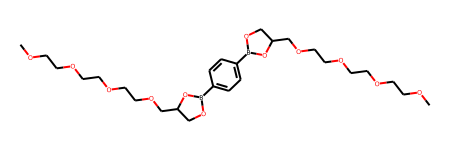

In [45]:
sm = 'COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)cc2)O1'
Chem.MolFromSmiles(sm)